## are the coexpression block boundries the same as TADs?

we define the start and end of a cluster as the start and end of its first and last gene. 


then we look to see if clusters overlap multiple TADs, or are contained within a single TAD.

In [120]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
import scipy as sp


In [11]:
# get output directories from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']


# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

### load in data

In [12]:
# download the tad boundries
# data from http://dna.cs.miami.edu/TADKB/search.php
tad_path = '/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs_hg38/converted_HiC_GM12878_DI_10kb.txt'
#tad_path = '/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs/HiC_CH12-LX_DI_10kb.txt'

tad_df = pd.read_csv(tad_path, header=None, sep='\t', names=['Chromosome', 'start','end'])
tad_df.head()

,Chromosome,start,end
0,chr1,804620,1294620
1,chr1,1324620,1748561
2,chr1,1778561,1918561
3,chr1,1918561,2388561
4,chr1,2388561,2678561


In [13]:
# annotate clusters with the start and end of the first and last gene
# download the gene list 
gtf_path = '/home/klawren/oak/pcqtls/data/references/gencode.v26.GRCh38.genes.gtf'

full_g = pr.read_gtf(gtf_path)
transcript_df = full_g[full_g.Feature == 'transcript'].df
transcript_df.set_index('transcript_id', inplace=True)
transcript_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,gene_name,transcript_type,transcript_name,level,havana_gene,exon_id,exon_number,tag
transcript_id,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,chr1,HAVANA,transcript,11868,14403,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,transcribed_unprocessed_pseudogene,DDX11L1,2,OTTHUMG00000000961.2,NaN,NaN,NaN
ENSG00000243485.5,chr1,HAVANA,transcript,29570,31109,.,+,.,ENSG00000243485.5,lincRNA,MIR1302-2HG,lincRNA,MIR1302-2HG,2,OTTHUMG00000000959.2,NaN,NaN,ncRNA_host
ENSG00000268020.3,chr1,HAVANA,transcript,52472,53312,.,+,.,ENSG00000268020.3,unprocessed_pseudogene,OR4G4P,unprocessed_pseudogene,OR4G4P,2,OTTHUMG00000185779.1,NaN,NaN,NaN
ENSG00000240361.1,chr1,HAVANA,transcript,62947,63887,.,+,.,ENSG00000240361.1,unprocessed_pseudogene,OR4G11P,unprocessed_pseudogene,OR4G11P,2,OTTHUMG00000001095.2,NaN,NaN,NaN
ENSG00000186092.4,chr1,HAVANA,transcript,69090,70008,.,+,.,ENSG00000186092.4,protein_coding,OR4F5,protein_coding,OR4F5,2,OTTHUMG00000001094.2,NaN,NaN,NaN


### start and end of clusters

In [14]:
def get_start(row):
    row_df = transcript_df.loc[row.Transcripts.split(',')]
    return row_df.Start.min()

def get_end(row):
    row_df = transcript_df.loc[row.Transcripts.split(',')]
    return row_df.End.max()

In [15]:
# df of clusters in all tissue types
cluster_dfs=[]
for tissue_id in tissue_ids:
    cluster_dfs.append(pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0))
clusters = pd.concat(cluster_dfs)

In [16]:
clusters['start'] = clusters.apply(get_start, axis=1)
clusters['end'] = clusters.apply(get_end, axis=1)
clusters['Chromosome']  = 'chr' + clusters['Chromosome'].astype(str)
clusters['log_size'] = np.log10(clusters['end'] - clusters['start'])
clusters['cluster_size'] = clusters['end'] - clusters['start']
clusters['inter'] = pd.arrays.IntervalArray.from_arrays(clusters['start'], clusters['end'])

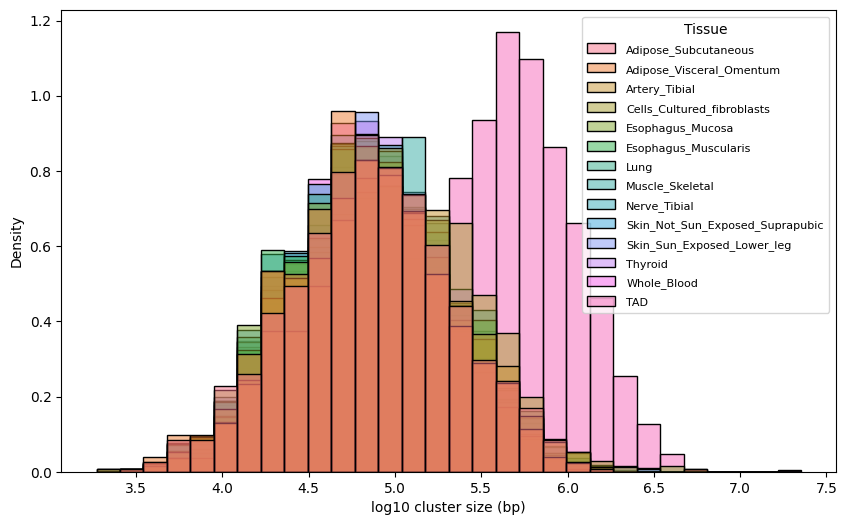

In [34]:
tad_df['log_size'] = np.log10(tad_df['end'] - tad_df['start'])
tad_df['Tissue'] = 'TAD'

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(pd.concat([clusters[['log_size', 'Tissue']], tad_df[['log_size', 'Tissue']]]), x='log_size', bins=bins, stat='density', hue='Tissue', common_norm=False, ax=ax)

ax.set_xlabel('log10 cluster size (bp)')
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
plt.show()

<Axes: xlabel='N_genes', ylabel='log_size'>

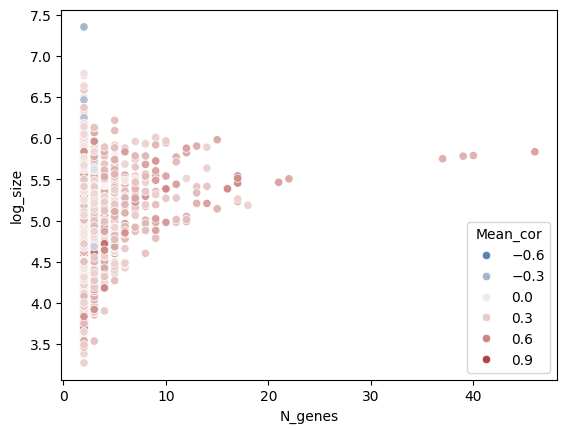

In [35]:
# are the larger clusters the ones with more genes? not really

sns.scatterplot(data=clusters, x='N_genes', y='log_size', hue='Mean_cor', palette='vlag')

### TAD overlap

In [36]:
# check how many tads each cluster overlaps
clusters['inter'] = pd.arrays.IntervalArray.from_arrays(clusters['start'], clusters['end'])
tad_df['inter'] = pd.arrays.IntervalArray.from_arrays(tad_df['start'], tad_df['end'])

def count_tad_overlap(row):
    tad_chr = tad_df[tad_df['Chromosome']==row.Chromosome]
    chr_tad_intervals = pd.arrays.IntervalArray.from_arrays(tad_chr['start'], tad_chr['end'])
    return sum(chr_tad_intervals.overlaps(row['inter']))

<Axes: xlabel='num_tads', ylabel='count'>

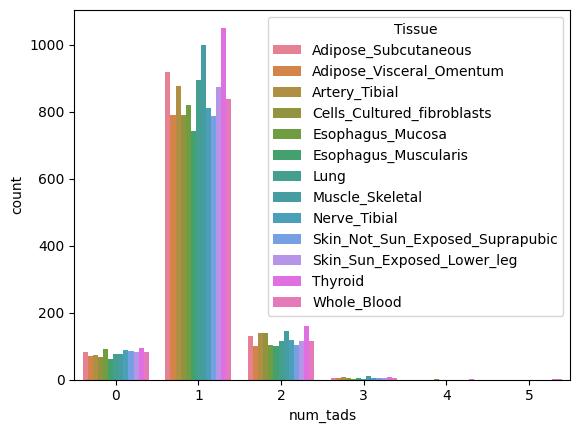

In [38]:
clusters['num_tads'] = clusters.apply(count_tad_overlap, axis=1)
sns.countplot(clusters, x='num_tads', hue='Tissue')

<Axes: xlabel='num_tads', ylabel='count'>

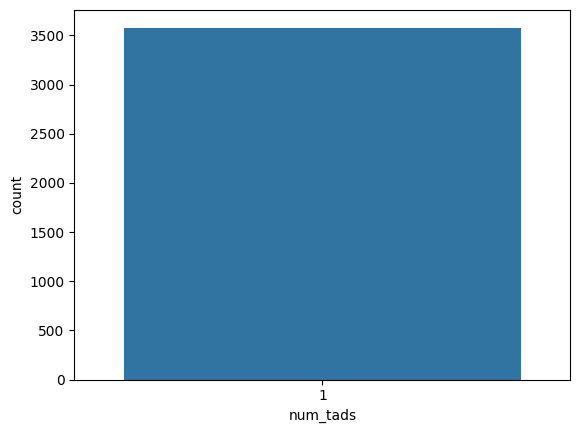

In [39]:
# sanity check to see if TADs are non-overlapping 
# this should all be 1
tad_df['num_tads'] = tad_df.apply(count_tad_overlap, axis=1)
sns.countplot(tad_df, x='num_tads')

## Null with gene number

It does look like most clusters are in only 1 TAD. But this could just be due to the fact that clusters are smaller than TADs! I need a null group. This could be 

* groups of similarly sized intervals to compare to. 
* groups of similar numbers of genes (need to check if these result in the same sized clusters)

In [40]:
# get random stretches of genes that are the same number, then check if they are the same distance distribution (roughly)
transcript_df = transcript_df[transcript_df.Chromosome.isin(clusters.Chromosome.unique())]
# sort genes and add an increasing index
transcript_df.sort_values(['Chromosome', 'Start'], inplace=True)
transcript_df.reset_index(inplace=True)

In [46]:
def get_null_num_genes(num=None):
    # chose how many genes to get 
    if num==None:
        num=len(clusters)
    # chose genes to be the start of the clusters
    transcript_df.sample(num, replace=True)
    # then extend by the number of genes in the cluster
    null_inter=[]
    for n in clusters.N_genes:
        diff_chr=True
        while diff_chr:
            sead_idx = np.random.randint(len(transcript_df))
            null_genes = transcript_df.iloc[sead_idx:sead_idx+n]
            diff_chr = (null_genes.iloc[0].Chromosome != null_genes.iloc[-1].Chromosome)
        null_inter.append([n, null_genes.transcript_id.values, null_genes.Chromosome.iloc[0], null_genes.Start.min(), null_genes.End.max()])
        
    null_df = pd.DataFrame(null_inter, columns=['N_genes', 'Transcripts', 'Chromosome', 'start', 'end'])
    null_df['inter'] = pd.arrays.IntervalArray.from_arrays(null_df['start'], null_df['end'])
    null_df['num_tads'] = null_df.apply(count_tad_overlap, axis=1)
    return null_df


<Axes: xlabel='num_tads', ylabel='count'>

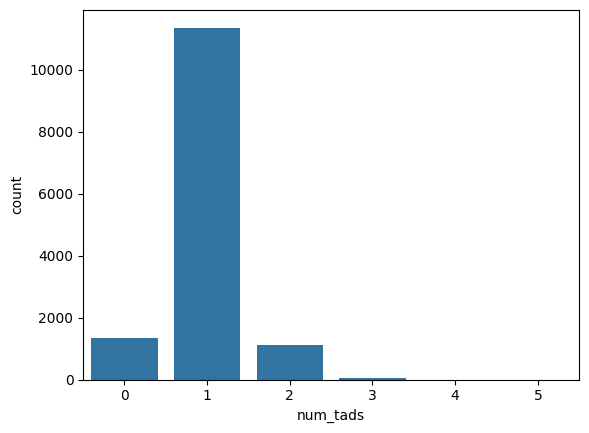

In [42]:
# check to see if null overlaps TADs
null_df = get_null_num_genes()
sns.countplot(null_df, x='num_tads')

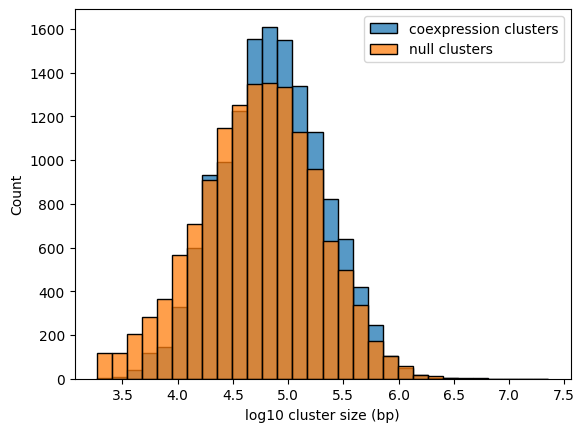

In [43]:
# check to see if inter-cluster distances are very different
_, bins = np.histogram(np.log10(clusters['end'] - clusters['start']), bins=30)
sns.histplot(np.log10(clusters['end'] - clusters['start']), label='coexpression clusters', bins=bins)
sns.histplot(np.log10(null_df['end'] - null_df['start']), label='null clusters', bins=bins)

plt.xlabel('log10 cluster size (bp)')
plt.legend()

they are roughly the same size, perhaps the null is slightly smaller. But that will make it a conservative null in terms of TADs overlapped

In [45]:
len(clusters)

13869

In [87]:
# generate a whole null distribution (more genes?)
null_df=get_null_num_genes(num=20000)
null_df['Tissue'] = 'null_num_genes'

# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']]], keys=['clusters', 'null_genes'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

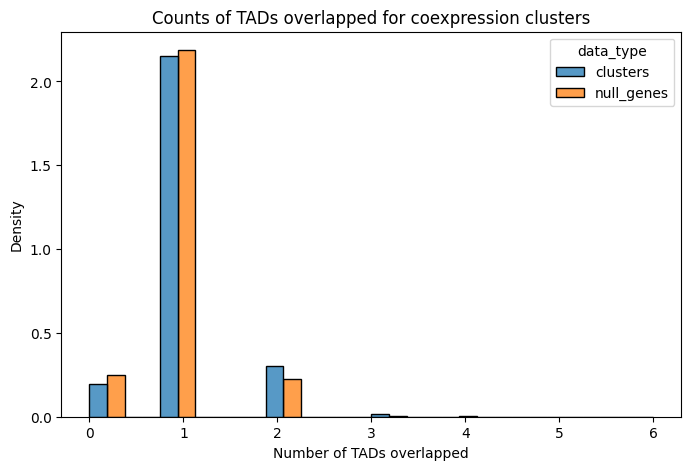

In [88]:
fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(plot_df, x='num_tads', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

In [75]:
# load in the chr lengths
genome_path = '/home/klawren/oak/coexp_eqtl/data/hg38.bed'
genome_df = pd.read_csv(genome_path, header=None, names=['Chromosome', 'start','end'], sep=' ')
genome_df.set_index('Chromosome', inplace=True)
genome_df.head()

,start,end
Chromosome,,
chr1,0,248956422
chr2,0,242193529
chr3,0,198295559
chr4,0,190214555
chr5,0,181538259


we could also do the null distribution based only on the length of the intervals

In [77]:
def get_null_dist(num=None):
    # chose how many genes to get 
    if num==None:
        num=len(clusters)
    null_inter=[]
    # go through each chromosome and get segments of length equal to the clusters there
    for chrom, sub_cluster in clusters.sample(num, replace=True).groupby('Chromosome'):
        idxs=[]
        for idx, row in sub_cluster.iterrows():
            idxs.append(np.random.randint(genome_df.loc[chrom]['end'] - row.cluster_size))

        null_inter.append(pd.DataFrame({'Chromosome':chrom, 'N_genes':len(sub_cluster), 'start':idxs, 'end':idxs + sub_cluster.cluster_size}))
    # make a df an annotate
    null_df = pd.concat(null_inter)
    null_df['inter'] = pd.arrays.IntervalArray.from_arrays(null_df['start'], null_df['end'])
    null_df['num_tads'] = null_df.apply(count_tad_overlap, axis=1)
    return null_df


In [89]:
null_dist_df = get_null_dist(num=20000)
null_dist_df['Tissue'] = 'null_interval_length'


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']], null_dist_df[['num_tads', 'Tissue']]], keys=['clusters', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

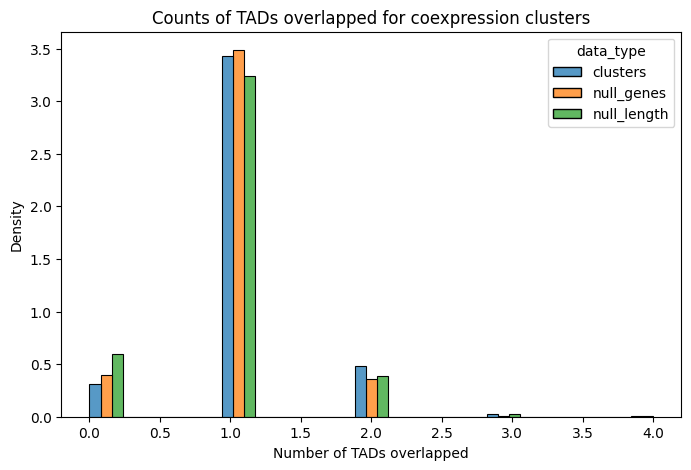

In [90]:
fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

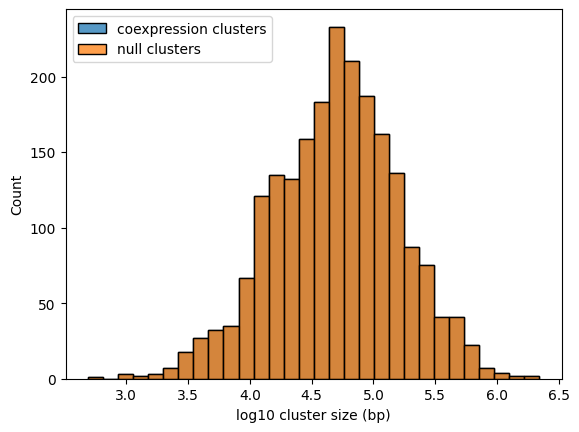

In [ ]:
# check to see if inter-cluster distances are the same (as expected)
_, bins = np.histogram(np.log10(clusters['end'] - clusters['start']), bins=30)
sns.histplot(np.log10(clusters['cluster_size']), label='coexpression clusters', bins=bins)
sns.histplot(np.log10(null_df['end'] - null_df['start']), label='null clusters', bins=bins)

plt.xlabel('log10 cluster size (bp)')
plt.legend()

In [106]:
# what if we restict just to clusters with positive corrleation?

partial_cluster = clusters[~clusters['Mean_neg_cor'].isna()]


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']],partial_cluster[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']], null_dist_df[['num_tads', 'Tissue']]], keys=['clusters', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

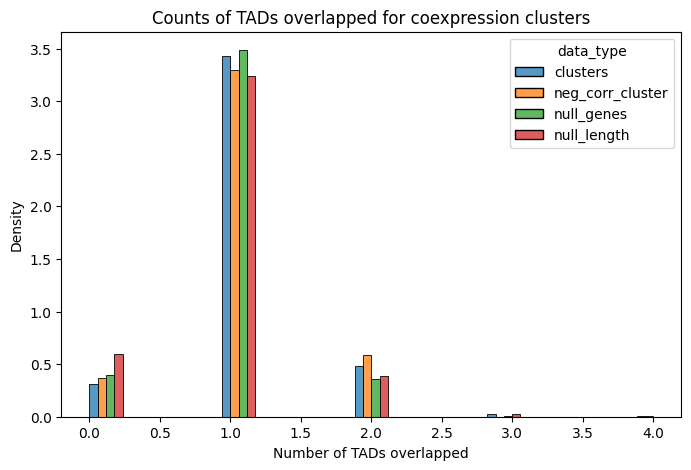

In [107]:
fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

the negative correlations do seem to overlap 2+ tads more often. Try comparing these to the high positive corrs

<Axes: xlabel='Mean_pos_cor', ylabel='Count'>

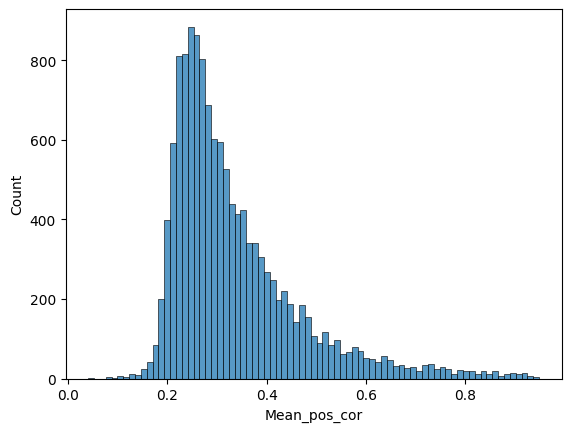

In [104]:
sns.histplot(clusters['Mean_pos_cor'])

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

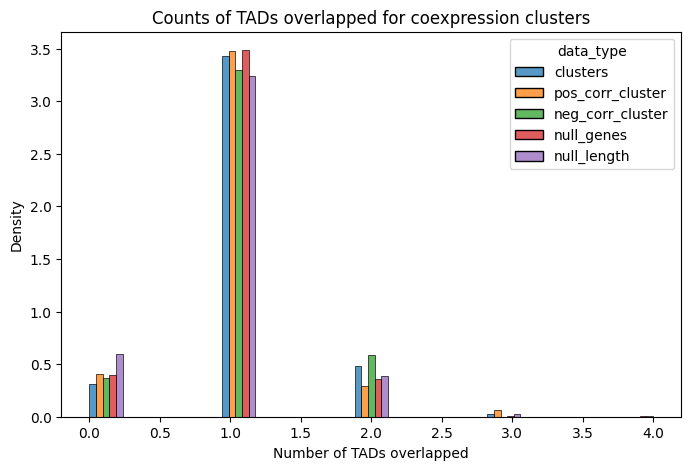

In [191]:
# what if we restict just to clusters with positive corrleation?

neg_cluster = clusters[~clusters['Mean_neg_cor'].isna()]

# pick .6 as a highish positive corr, and requrie the cluster has no negative corr
pos_cluster = clusters[(clusters['Mean_neg_cor'].isna()) & (clusters['Mean_pos_cor']>.6)]


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], 
                     pos_cluster[['num_tads', 'Tissue']], 
                     neg_cluster[['num_tads', 'Tissue']], 
                     null_df[['num_tads', 'Tissue']], 
                     null_dist_df[['num_tads', 'Tissue']]], 
                     keys=['clusters', 'pos_corr_cluster', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')


I do see a differnece, with pos corr clusters more likely to be in one TAD, and neg corr clusters more likely to cross tads. But could this be due to different sizes of the pos and neg clusters?

<Axes: xlabel='log_size', ylabel='Count'>

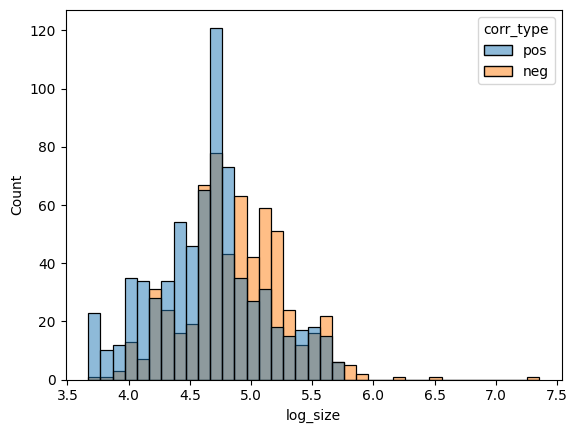

In [192]:
# are the length distributions differnt?

pos_neg_df = pd.DataFrame(pd.concat([pos_cluster['log_size'], neg_cluster['log_size']], keys=['pos', 'neg'])).reset_index(names=['corr_type', 'idx'])
sns.histplot(pos_neg_df, x= 'log_size', hue='corr_type')

The lnegth distributions are different, so I will resample them to match 

In [193]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)

In [194]:
len(pos_cluster) > len(neg_cluster)
# so resample from pos cluster to match neg cluster

True

In [195]:
candidate_pool = (pos_cluster['log_size']/clusters['log_size'].max())
target = (neg_cluster['log_size']/clusters['log_size'].max())

n=1000

resamp_idxs_pos = resample_dist(target, candidate_pool, n)
resamp_idxs_neg = resample_dist(target, target, n)

<Axes: xlabel='log_size', ylabel='Count'>

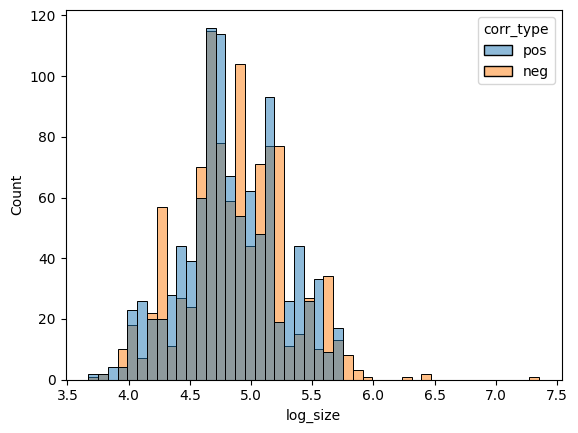

In [196]:
pos_neg_df = pd.DataFrame(pd.concat([pos_cluster.iloc[resamp_idxs_pos], neg_cluster.iloc[resamp_idxs_neg]], keys=['pos', 'neg'])).reset_index(names=['corr_type', 'idx'])
sns.histplot(pos_neg_df, x= 'log_size', hue='corr_type')

That's a better match. Lets look at TAD overlap again

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

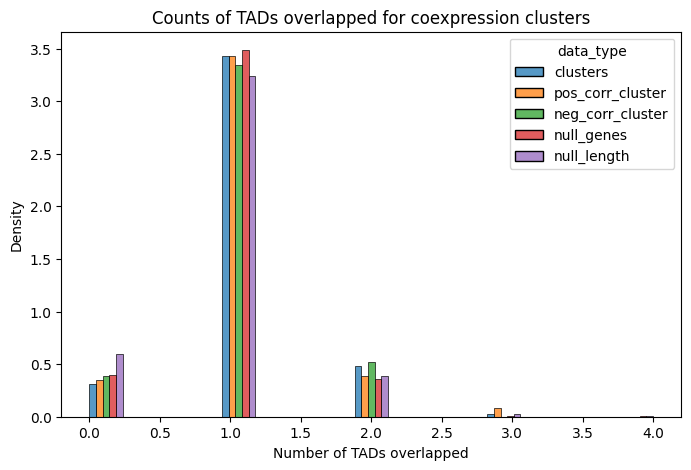

In [197]:
# what if we restict just to clusters with positive corrleation?

# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], 
                     pos_cluster.iloc[resamp_idxs_pos][['num_tads', 'Tissue']], 
                     neg_cluster.iloc[resamp_idxs_neg][['num_tads', 'Tissue']], 
                     null_df[['num_tads', 'Tissue']], 
                     null_dist_df[['num_tads', 'Tissue']]], 
                     keys=['clusters', 'pos_corr_cluster', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

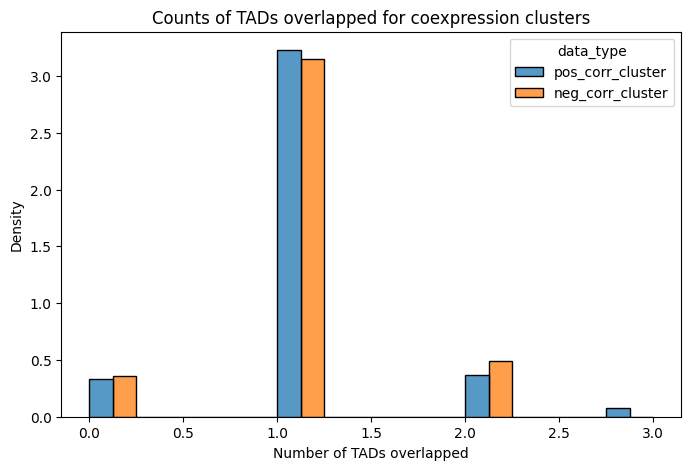

In [202]:
# what if we restict just to clusters with positive corrleation?

# make into one df
plot_df = pd.concat([pos_cluster.iloc[resamp_idxs_pos][['num_tads', 'Tissue']], 
                     neg_cluster.iloc[resamp_idxs_neg][['num_tads', 'Tissue']]], 
                     keys=['pos_corr_cluster', 'neg_corr_cluster'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(plot_df, x='num_tads', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')


but is this signifigant? one way to get error bars would be to resample a few times, then use the std of that resampling

In [237]:
# what if we restict just to clusters with positive corrleation?
pos_counts=[]
neg_counts=[]
for i in tqdm(range(100)):
    n=100
    resamp_idxs_pos = resample_dist(target, candidate_pool, n, seed=i)
    resamp_idxs_neg = resample_dist(target, target, n, seed=i)
    pos_counts.append(pos_cluster.iloc[resamp_idxs_pos]['num_tads'].value_counts())
    neg_counts.append(neg_cluster.iloc[resamp_idxs_neg]['num_tads'].value_counts())


100%|█████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Text(0, 0.5, 'Fraction clusters')

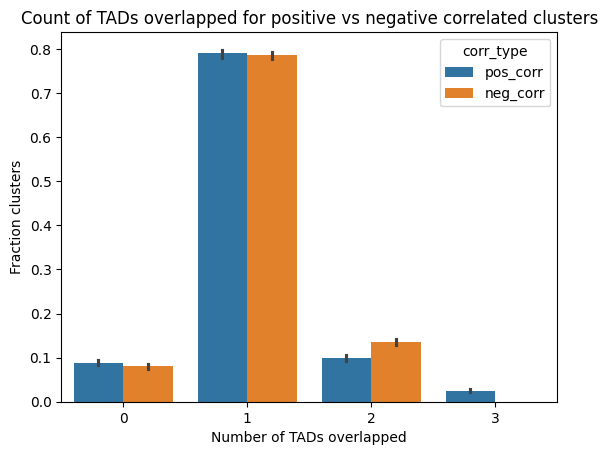

In [239]:
# normalize (since the total count vlaues are meaningless)
pos_counts_normed = [counts/np.sum(counts) for counts in pos_counts]
neg_counts_normed = [counts/np.sum(counts) for counts in neg_counts]

# combine into one df
plot_df = pd.concat([pd.concat(pos_counts_normed), pd.concat(neg_counts_normed)], keys=['pos_corr', 'neg_corr']).reset_index()
plot_df.rename(columns={'level_0':'corr_type'}, inplace=True)

# plot
sns.barplot(plot_df, hue='corr_type', y='count', x='num_tads')
plt.title('Count of TADs overlapped for positive vs negative correlated clusters')

plt.xlabel('Number of TADs overlapped')
plt.ylabel('Fraction clusters')
